In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil
import shelve
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from itertools import combinations

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from inspector.app.utils import get_feature_values
from inspector.app.utils.model import Model
from inspector.app.views import gather_values

import re
from gensim.models.word2vec import Word2Vec


SEED = 25

C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.1 whe

In [2]:
df = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\classification_dataset.csv')
df['class'] = round(df['class'] / 10).astype(int)
df = df[df['class'] != 1]
_type = df['type'].to_list()
df = df.drop(['name', 'side_mistake',
              'vs', 'squared_vs', 'ttr', 'root_ttr',
              'log_ttr', 'uber_ttr', 'd', 'vvi',
              'squared_vv', 'punct_mistakes_pp',
              'punct_mistakes_because',
              'punct_mistakes_but', 'punct_mistakes_compare'], axis=1)

df.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_linkings,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,text,class,type,sum_punct
0,3.56,6,2,2,0,1,18,244,4.39,13.56,...,5,1,0,0,2,0,This two line graphs illustrates monthly avera...,6,1,0
1,5.43,10,4,1,3,1,7,175,6.29,25.00,...,6,1,0,0,3,0,"﻿We have two graphics, which show us the popul...",6,1,0


In [10]:
df['class'].value_counts()

6    2680
7     308
5     215
4     122
8      77
2      24
3      14
Name: class, dtype: int64

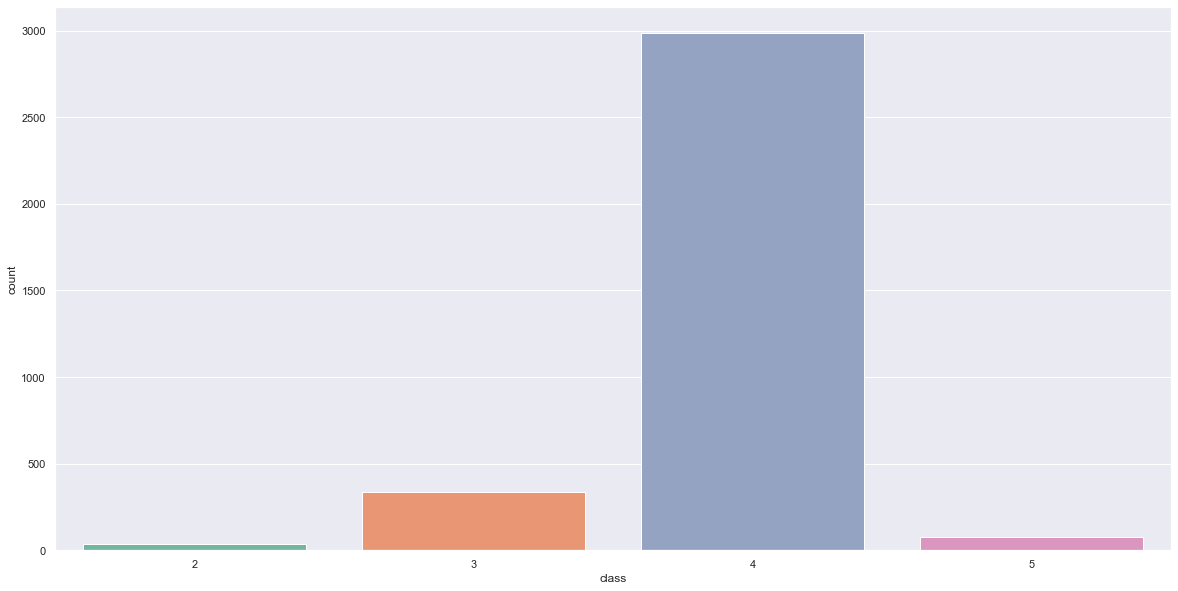

In [11]:
df.loc[df['class'] == 1, 'class'] = 2
df.loc[df['class'] == 3, 'class'] = 2
df.loc[df['class'] == 4, 'class'] = 3
df.loc[df['class'] == 5, 'class'] = 3
df.loc[df['class'] == 6, 'class'] = 4
df.loc[df['class'] == 7, 'class'] = 4
df.loc[df['class'] == 8, 'class'] = 5

sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='class', data=df, palette="Set2")

In [12]:
df = df.rename(columns = {'class': 'cls'})
feature_columns = [col for col in df.columns if col not in ['cls',]]
X = df[feature_columns]
y = df['cls']
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state = SEED)

Т.к. имеем очень малое количество текстов во всех классах кроме 4, то сгенерируем тексты скомпоновав их половины

In [3]:
df_gen = pd.read_csv(r'D:\hse_iot\VKR\my_inspector\data\generated_data.csv', index_col='idx')
df_gen.drop(['squared_vs', 'root_ttr', 'uber_ttr', 'ttr', 'd', 'vvi', 'squared_vv', 'vs', 'log_ttr'],  inplace=True, axis=1)
df_gen.head(2)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_pres_plur,num_past_part,num_past_simple,num_linkings,num_4grams,num_func_ngrams,million_mistake,text,sum_punct,cls
idx,,,,,,,,,,,,,,,,,,,,,
0,3.69,7,2,2,2,0,13,189,4.23,14.54,...,0,2,4,6,3,1,0,The graph illustrates the market situation abo...,0,4
1,3.93,7,2,1,3,1,15,244,4.80,16.27,...,0,3,0,13,2,0,0,There is a linegraph and piechart. The linegra...,0,4


In [4]:
df_gen.text.iloc[157]

'The pie charts provide the information about transportation of different goods between east Europe countries in 2008. One pie chart is about goods transported by rail another by road.\r\n\r\nIt can be seen that metals are often transported by rail it is 35%. And the most transported by road is a food products. Form the charts it is clear that the way of chemicals transportation is not very important, because numbers are fast the same. What about machinery it prefer to transport by rail and only 2% of machinery goods are transported by road. Non-metallic minerals is better to transport by road. Comparing two pie charts it can be see that both ways of transportation are popular and the choice hangs what kind of goods need to transport the most convenient way to metals transportations is rail, and to food products transportation is road. Machinery goods are transported by road seldom.\r\n'

In [5]:
df_gen['cls'].value_counts()

5    2441
4    2386
3    2257
2    2016
Name: cls, dtype: int64

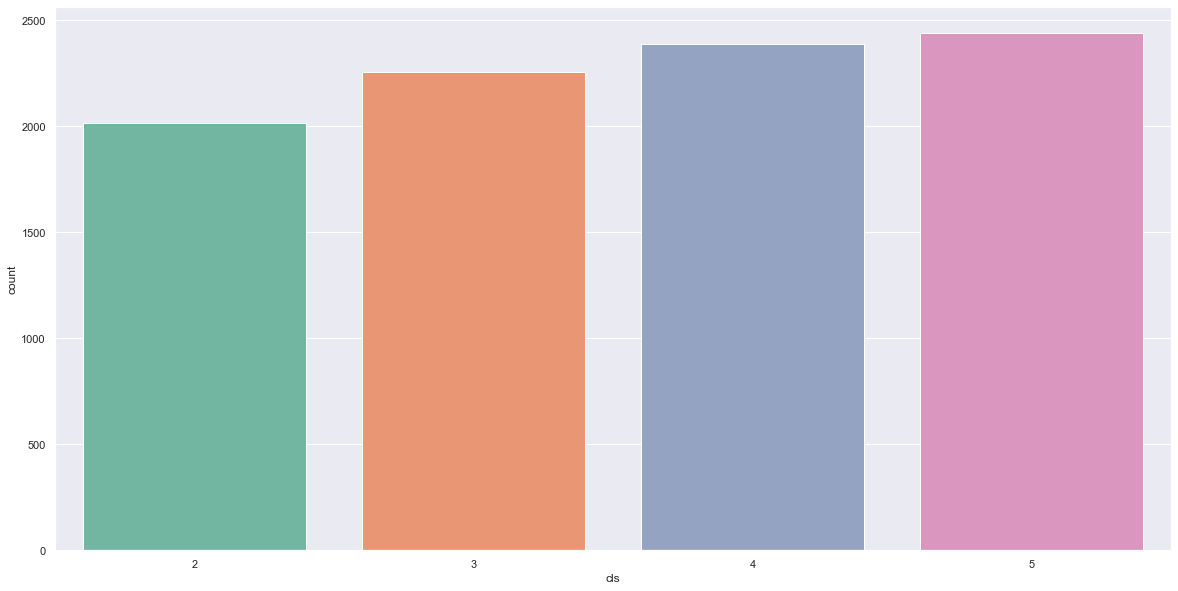

In [6]:
sns.set(rc={'figure.figsize':(20,10)})
sns_plt = sns.countplot(x='cls', data=df_gen, palette="Set2")

In [7]:
def get_results(clf, train_x, train_y, test_x, test_y):
    print('         -----------Train data res------------\n')
    pred_y = cross_val_predict(clf, train_x, train_y, cv=10)
    print(classification_report(train_y, pred_y))
    print('Confusion matrix: \n\n', confusion_matrix(train_y, pred_y))
    
    print('\n       -----------Test data res------------\n')
    clf.fit(train_x, train_y)
    pred_y = clf.predict(test_x)
    print(classification_report(test_y, pred_y))
    print('Confusion matrix: \n\n', confusion_matrix(test_y, pred_y))

# Cтатистические модели на половинах текстов

In [8]:
feature_cols = [i for i in df_gen.columns if i not in ['cls', 'text']]

### KNN

In [13]:
get_results(KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'),
           df_gen[feature_cols],
           df_gen['cls'],
           test_x[feature_cols],
           test_y)

         -----------Train data res------------

              precision    recall  f1-score   support

           2       0.81      0.85      0.83      2016
           3       0.76      0.62      0.68      2257
           4       0.88      0.98      0.93      2386
           5       0.86      0.88      0.87      2441

    accuracy                           0.84      9100
   macro avg       0.83      0.83      0.83      9100
weighted avg       0.83      0.84      0.83      9100

Confusion matrix: 

 [[1721  211    0   84]
 [ 390 1390  222  255]
 [   5   30 2346    5]
 [  12  190   87 2152]]

       -----------Test data res------------

              precision    recall  f1-score   support

           2       0.33      0.25      0.29         8
           3       0.86      0.50      0.63        76
           4       0.92      0.99      0.95       587
           5       0.83      0.29      0.43        17

    accuracy                           0.91       688
   macro avg       0.74      0.

In [14]:
import pickle

In [15]:
knn = KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')
knn.fit(df_gen[feature_cols], df_gen['cls'])

KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')

In [40]:
test_x

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_past_simple,num_linkings,num_4grams,num_func_ngrams,num_shell_noun,num_misspelled_tokens,million_mistake,text,type,sum_punct
265,4.35,7,2,6,6,6,17,323,5.41,19.00,...,4,18,8,2,8,4,0,It is a well known fact that people today have...,2,1
1009,5.78,9,2,2,2,5,9,208,4.56,23.11,...,3,4,6,1,1,11,10,This chart as we can see characterized how muc...,1,0
1130,5.00,7,2,5,1,9,14,303,4.21,21.64,...,1,15,5,2,6,2,0,With the industrialisation and modernisation o...,2,1
579,3.12,5,2,0,0,4,26,312,3.12,12.00,...,6,13,22,5,3,2,0,Technologies are an essential part of modern l...,2,0
1665,5.07,9,3,5,3,6,14,321,6.64,22.93,...,2,9,21,4,4,1,0,"At present there is a trend of air travel, tha...",2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,5.78,8,3,4,4,5,9,225,9.67,25.00,...,2,11,9,2,2,6,0,"﻿To start with, we live in the deloping world ...",2,1
1964,4.00,7,2,2,1,1,6,91,5.67,15.17,...,2,3,0,0,1,1,0,Today the most of people every day use technol...,2,0
3331,3.12,4,2,4,0,3,16,207,6.06,12.94,...,2,9,0,0,0,5,0,The chart shows changes in the unemployment ra...,1,1
207,5.33,9,2,7,3,5,9,237,6.56,26.33,...,1,12,4,1,0,7,0,﻿The bar chart illustrates the distribution of...,1,0


In [69]:
test_x[test_y == 5].text.to_list()[15]

'\ufeffThe bar chart illustrates the proportion of the usage of three social networks by adults belonging to different age groups in the United States.\r\n\r\nIt can be clearly seen that Facebook is the most popular online network among all age groups, with more than four-fifth of people aged from 18 to 29 and more than a half of the people from other age groups using it.\r\nOn the contrary, Instagram and LinkedIn are not as widely used. While slightly more than a half of the younger generation have an Instagram account, only a quarter of people aged from 30 to 49 communicate via this network. As for those who are 50 years old or more, Instagram users make up a small minority.\r\nThe difference in the percentage of those who have LinkedIn accounts is less dramatic. The proportion of users aged from 18 to 29 and those who are at least 65 years old is equal, making up 22 per cent. The figures for those who belong to other age groups, 30-49 and 50-64 years old, are almost identical, with 

In [41]:
knn.predict(test_x[feat])[0]

ValueError: could not convert string to float: 'It is a well known fact that people today have a lot of problems with their health because of the use of computers and other technologied devices. Some of this problems are very serious, some of them can be easily reduced. \r\n\r\nThe most common problem for people nowadays is the lack of mobility. We spend a great part of the day sitting by our computers. People who work sit near the computer almost 8 hours without even getting up. Even students who are supposed to be healthy and active suffer from this problem. To reduce this issue, special exercises brakes can be introduced in offices, maybe even in universities and schools. It is crucial to have some resting time during work and studying, but it’s also important for this break to be helpful physically and mentaly. And of course let’s not forget about the healthy diet a person should have and the importance of staying hidrated. \r\n\r\nAnother problem that is discussed a lot today is peoples’ dependence on mobile phones and the internet.  A lot of my friends agree that they can’t live without  their phones. The constant need of communication and information stays behind that. However, I think that sometimes we need to have some tome for ourselves. Therefore one of the ways of dealing with this particular problem would be meditation. It is an easy way to relax and ger yourself together, clear  your head from all the unnecessary information that comes to us everyday. In my opinion, this is a great habbit everybody can develop. \r\n\r\nTo conclude, I can say that despite the fact that we live in a world  full of modern technology, we shouldn’t be lazy and we shouldn’t forget to take care of our personal health.\r\n'

### RF

In [58]:
get_results(RandomForestClassifier(max_depth=33, max_features='sqrt', min_samples_split=7, n_estimators=702),
           df_gen[feature_cols],
           df_gen['cls'],
           test_x[feature_cols],
           test_y)

         -----------Train data res------------

              precision    recall  f1-score   support

           2       0.93      0.93      0.93      2016
           3       0.88      0.79      0.83      2257
           4       0.87      0.99      0.93      2386
           5       0.94      0.90      0.92      2441

    accuracy                           0.90      9100
   macro avg       0.90      0.90      0.90      9100
weighted avg       0.90      0.90      0.90      9100

Confusion matrix: 

 [[1867  117    1   31]
 [ 145 1783  225  104]
 [   1   22 2358    5]
 [   3  115  114 2209]]

       -----------Test data res------------

              precision    recall  f1-score   support

           2       0.50      0.25      0.33         8
           3       0.83      0.46      0.59        76
           4       0.91      0.99      0.95       587
           5       0.00      0.00      0.00        17

    accuracy                           0.90       688
   macro avg       0.56      0.

### XGB

In [62]:
get_results(xgb.XGBRFClassifier(colsample_bytree=0.4,
                gamma=0.1,
                learning_rate=0.3,
                max_depth=12,
                min_child_weight=1,
                n_estimators=638,
                reg_alpha=0,
                reg_lambda=0.01,
                subsample=1),
           df_gen[feature_cols],
           df_gen['cls'],
           test_x[feature_cols],
           test_y)

         -----------Train data res------------



C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:04:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

### SVM

In [64]:
get_results(SVC(C=5,
                class_weight='balanced',
                decision_function_shape='ovr',
                gamma='scale',
                kernel='rbf'),
           df_gen[feature_cols],
           df_gen['cls'],
           test_x[feature_cols],
           test_y)

         -----------Train data res------------

              precision    recall  f1-score   support

           2       0.80      0.80      0.80      2016
           3       0.70      0.63      0.67      2257
           4       0.88      0.99      0.93      2386
           5       0.88      0.85      0.87      2441

    accuracy                           0.82      9100
   macro avg       0.82      0.82      0.82      9100
weighted avg       0.82      0.82      0.82      9100

Confusion matrix: 

 [[1605  340    2   69]
 [ 401 1432  222  202]
 [   3   10 2369    4]
 [   5  261   98 2077]]

       -----------Test data res------------

              precision    recall  f1-score   support

           2       0.43      0.38      0.40         8
           3       0.70      0.09      0.16        76
           4       0.87      1.00      0.93       587
           5       0.00      0.00      0.00        17

    accuracy                           0.86       688
   macro avg       0.50      0.

C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
from sklearn.ensemble import StackingClassifier, VotingClassifier

In [92]:
estimators = [('knn', KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')),
              ('rf', RandomForestClassifier(max_depth=33, max_features='sqrt', min_samples_split=7, n_estimators=702)),
              ('xgb', xgb.XGBRFClassifier(colsample_bytree=0.4,
                gamma=0.1,
                learning_rate=0.3,
                max_depth=12,
                min_child_weight=1,
                n_estimators=638,
                reg_alpha=0,
                reg_lambda=0.01,
                subsample=1)),
              ('svm', SVC(C=5,
                class_weight='balanced',
                decision_function_shape='ovr',
                gamma='scale',
                kernel='rbf'))]
clf = StackingClassifier(estimators=estimators, final_estimator= RandomForestClassifier(), n_jobs=-1)

In [93]:
get_results(clf,
           df_gen[feature_cols],
           df_gen['cls'],
           test_x[feature_cols],
           test_y)

         -----------Train data res------------



C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


              precision    recall  f1-score   support

           2       0.93      0.94      0.93      2016
           3       0.91      0.80      0.85      2257
           4       0.88      0.99      0.93      2386
           5       0.96      0.92      0.94      2441

    accuracy                           0.92      9100
   macro avg       0.92      0.91      0.91      9100
weighted avg       0.92      0.92      0.91      9100

Confusion matrix: 

 [[1894  101    2   19]
 [ 135 1810  234   78]
 [   0   10 2370    6]
 [  12   74  102 2253]]

       -----------Test data res------------

              precision    recall  f1-score   support

           2       0.50      0.25      0.33         8
           3       0.83      0.20      0.32        76
           4       0.88      0.99      0.94       587
           5       0.50      0.12      0.19        17

    accuracy                           0.88       688
   macro avg       0.68      0.39      0.44       688
weighted avg       0.86  

In [106]:
estimators = [('knn', KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')),
              ('rf', RandomForestClassifier(max_depth=33, max_features='sqrt', min_samples_split=7, n_estimators=702)),
              ('xgb', xgb.XGBRFClassifier(colsample_bytree=0.4,
                gamma=0.1,
                learning_rate=0.3,
                max_depth=12,
                min_child_weight=1,
                n_estimators=638,
                reg_alpha=0,
                reg_lambda=0.01,
                subsample=1)),
              ('svm', SVC(C=5,
                class_weight='balanced',
                decision_function_shape='ovr',
                gamma='scale',
                kernel='rbf',
                probability = True))]
clf = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

In [107]:
get_results(clf,
           df_gen[feature_cols],
           df_gen['cls'],
           test_x[feature_cols],
           test_y)

         -----------Train data res------------

              precision    recall  f1-score   support

           2       0.86      0.87      0.86      2016
           3       0.81      0.70      0.75      2257
           4       0.88      0.99      0.93      2386
           5       0.90      0.90      0.90      2441

    accuracy                           0.87      9100
   macro avg       0.86      0.86      0.86      9100
weighted avg       0.86      0.87      0.86      9100

Confusion matrix: 

 [[1752  190    0   74]
 [ 278 1579  225  175]
 [   3   19 2358    6]
 [   3  151   96 2191]]

       -----------Test data res------------

              precision    recall  f1-score   support

           2       0.40      0.25      0.31         8
           3       0.89      0.45      0.60        76
           4       0.91      0.99      0.95       587
           5       0.00      0.00      0.00        17

    accuracy                           0.90       688
   macro avg       0.55      0.

### Binary classification

In [10]:
def prp2bin_clf(train_data, test_y, cls):
    train_data_res = train_data.copy()
    test_y_res = test_y.copy()
    
    train_data_res.loc[train_data_res['cls'] != cls, 'cls'] = 0
    train_data_res.loc[train_data_res['cls'] == cls, 'cls'] = 1
    
    test_y_res.loc[test_y_res != cls] = 0
    test_y_res.loc[test_y_res == cls] = 1
    
    return train_data_res, test_y_res

In [24]:
data_dict = {}

data_dict[2] = prp2bin_clf(df_gen, test_y, 2)
data_dict[3] = prp2bin_clf(df_gen, test_y, 3)
data_dict[4] = prp2bin_clf(df_gen, test_y, 4)
data_dict[5] = prp2bin_clf(df_gen, test_y, 5)


In [28]:
clf_dict = {}

clf_dict[2] = RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=2,
                                     min_samples_split=6, n_estimators=757)
clf_dict[3] = SVC(C=990, class_weight='balanced', decision_function_shape='ovo', gamma=0.1,
                  max_iter=10000)
clf_dict[4] = KNeighborsClassifier(n_neighbors=20, weights='distance')
clf_dict[5] = KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')

In [29]:
class Bin_clf():
    # train_acc: 2 = 89, 3 = 75, 4 = 96, 5 = 86
    
    def __init__(self, train_data, test_x, test_y, clf_dict):
        self.clf_2 = clf_dict[2]
        self.clf_3 = clf_dict[3]
        self.clf_4 = clf_dict[4]
        self.clf_5 = clf_dict[5]
        
        self.feature_cols = [i for i in train_data.columns if i not in ['cls', 'text']]
        
        def prp2bin_clf(train_data, test_y, cls):
            train_data_res = train_data.copy()
            test_y_res = test_y.copy()
    
            train_data_res.loc[train_data_res['cls'] != cls, 'cls'] = 0
            train_data_res.loc[train_data_res['cls'] == cls, 'cls'] = 1
    
            test_y_res.loc[test_y_res != cls] = 0
            test_y_res.loc[test_y_res == cls] = 1
    
            return train_data_res, test_y_res
        
        self.train_2, self.test_y_2 = prp2bin_clf(train_data, test_y, 2)
        self.train_3, self.test_y_3 = prp2bin_clf(train_data, test_y, 3)
        self.train_4, self.test_y_4 = prp2bin_clf(train_data, test_y, 4)
        self.train_5, self.test_y_5 = prp2bin_clf(train_data, test_y, 5)
        
        self.train_x_2 = self.train_2[self.feature_cols]
        self.train_x_3 = self.train_3[self.feature_cols]
        self.train_x_4 = self.train_4[self.feature_cols]
        self.train_x_5 = self.train_5[self.feature_cols]
        
        self.train_y_2 = self.train_2.cls
        self.train_y_3 = self.train_3.cls
        self.train_y_4 = self.train_4.cls
        self.train_y_5 = self.train_5.cls
        
        self.test_x = test_x[self.feature_cols]
        self.test_y = test_y
    
    def fit(self):
        self.clf_2.fit(self.train_x_2, self.train_y_2)
        self.clf_3.fit(self.train_x_3, self.train_y_3)
        self.clf_4.fit(self.train_x_4, self.train_y_4)
        self.clf_5.fit(self.train_x_5, self.train_y_5)
    
    def predict(self):
        pred_y_4_df = pd.DataFrame(self.clf_4.predict(self.test_x), index=self.test_x.index, columns=['res',])
        res = pred_y_4_df[pred_y_4_df['res'].isin([1,])]
        res = res.replace(1, 4)
        test_x_2 = self.test_x.loc[pred_y_4_df[pred_y_4_df['res'].isin([0,])].index]
        
        pred_y_2_df = pd.DataFrame(self.clf_2.predict(test_x_2), index=test_x_2.index, columns=['res',])
        res = pd.concat([res, pred_y_2_df[pred_y_2_df['res'].isin([1,])]], ignore_index=False)
        res = res.replace(1, 2)
        test_x_5 = test_x_2.loc[pred_y_2_df[pred_y_2_df['res'].isin([0,])].index]
        
        pred_y_5_df = pd.DataFrame(self.clf_5.predict(test_x_5), index=test_x_5.index, columns=['res',])
        res = pd.concat([res, pred_y_5_df[pred_y_5_df['res'].isin([1,])]], ignore_index=False)
        res = res.replace(1, 5)
        
        rest = pred_y_5_df[pred_y_5_df['res'].isin([0,])]
        pred_y_3_df = pd.DataFrame([3 for i in range(rest.index.shape[0])], index=rest.index, columns=['res',])
        res = pd.concat([res, pred_y_3_df], ignore_index=False)
        
        return res

In [108]:
bin_clf = Bin_clf(df_gen, test_x, test_y, clf_dict)

In [109]:
bin_clf.fit()

C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [125]:
pred_y_bin = bin_clf.predict()
pred_y_bin.res.value_counts()

4    632
3     46
5      6
2      4
Name: res, dtype: int64

In [127]:
print(classification_report(test_y, pred_y_bin))
print(confusion_matrix(pred_y_bin, test_y))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         8
           3       0.15      0.09      0.11        76
           4       0.86      0.92      0.89       587
           5       0.00      0.00      0.00        17

    accuracy                           0.80       688
   macro avg       0.25      0.25      0.25       688
weighted avg       0.75      0.80      0.77       688

[[  0   0   4   0]
 [  2   7  37   0]
 [  6  68 541  17]
 [  0   1   5   0]]


## W2V

In [11]:
with shelve.open('data\\w2v_wiki', flag='r') as w2v_file:
    w2v = w2v_file['w2v']

In [12]:
class W2V( BaseEstimator, TransformerMixin ):
    def __init__( self):
        with shelve.open('data\\w2v_wiki', flag='r') as w2v_file:
            self.w2v = w2v_file['w2v']
        self.index2word_set = set(self.w2v.index2word)
        
    def fit( self, X, y = None ):
        return self 
    
    def text_to_words(self, text):
        model = Model(r'D:\hse_iot\VKR\my_inspector\inspector\app\data\models\english-partut-ud-2.3-181115.udpipe')
        gf = get_feature_values.GetFeatures(model)
        gf.get_info(text)
        
        words = []
        for sent in gf.sentences:
            sent_list = []
            for word in sent:
                lemma = word.get('lemma')
                if re.sub('[^a-zA-Zа-яА-яёЁ]', '', lemma) != '':
                    sent_list.append(lemma)
            words.extend(sent_list)
        return words
    
    def text_to_vec(self, text):
        text_vec = np.zeros((self.w2v.vector_size,), dtype="float32")
        n_words = 0
        
        for word in self.text_to_words(text):
            if word in self.index2word_set:
                n_words = n_words + 1
                text_vec = np.add(text_vec, self.w2v[word]) 
        
        if n_words != 0:
            text_vec /= n_words
        return text_vec
    
    def transform( self, X, y = None ):
        w2v_vectors = [self.text_to_vec(text) for text in X.text]
        w2v_vectors_df = pd.DataFrame([i for i in w2v_vectors], columns=['w2v_' + str(i) for i in range(w2v_vectors[0].shape[0])])
        w2v_vectors_df.index = X.index
        X = X.join(w2v_vectors_df)
    
        return X.drop('text', axis=1)

In [13]:
clf_W2V = Pipeline(steps=[('data_W2V', W2V()),
                          ('clf', KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'))])

In [14]:
feature_cols = [i for i in df_gen.columns if i not in ['cls',]]

In [15]:
get_results(clf_W2V,
           df_gen[feature_cols],
           df_gen['cls'],
           test_x[feature_cols],
           test_y)

         -----------Train data res------------

              precision    recall  f1-score   support

           2       0.81      0.85      0.83      2016
           3       0.77      0.62      0.69      2257
           4       0.88      0.98      0.93      2386
           5       0.86      0.88      0.87      2441

    accuracy                           0.84      9100
   macro avg       0.83      0.84      0.83      9100
weighted avg       0.83      0.84      0.83      9100

Confusion matrix: 

 [[1721  212    0   83]
 [ 384 1400  222  251]
 [   5   27 2349    5]
 [  12  183   87 2159]]

       -----------Test data res------------

              precision    recall  f1-score   support

           2       0.33      0.25      0.29         8
           3       0.84      0.50      0.63        76
           4       0.92      0.99      0.95       587
           5       0.83      0.29      0.43        17

    accuracy                           0.91       688
   macro avg       0.73      0.

In [16]:
len(clf_W2V.named_steps.data_W2V.index2word_set)

999999

### Bin_clf_W2V

In [17]:
W2V_transformer = W2V()

In [23]:
train_x_w2V = W2V_transformer.transform(df_gen[feature_cols])

In [26]:
test_x_w2V = W2V_transformer.transform(test_x)

In [27]:
clf_dict = {}

clf_dict[2] = RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=2,
                                     min_samples_split=6, n_estimators=757)
clf_dict[3] = SVC(C=990, class_weight='balanced', decision_function_shape='ovo', gamma=0.1,
                  max_iter=10000)
clf_dict[4] = KNeighborsClassifier(n_neighbors=20, weights='distance')
clf_dict[5] = KNeighborsClassifier(n_neighbors=7, p=1, weights='distance')

In [34]:
bin_clf = Bin_clf(train_x_w2V.join(train_y), test_x_w2V, test_y, clf_dict)

In [35]:
bin_clf.fit()

C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [36]:
pred_y_bin_w2v = bin_clf.predict()
pred_y_bin_w2v.res.value_counts()

4.0    584
3.0    101
5.0      3
Name: res, dtype: int64

In [37]:
print(classification_report(test_y, pred_y_bin_w2v))
print(confusion_matrix(pred_y_bin_w2v, test_y))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         8
           3       0.12      0.16      0.14        76
           4       0.86      0.85      0.85       587
           5       0.00      0.00      0.00        17

    accuracy                           0.74       688
   macro avg       0.24      0.25      0.25       688
weighted avg       0.74      0.74      0.74       688

[[  0   0   0   0]
 [  3  12  84   2]
 [  5  64 500  15]
 [  0   0   3   0]]


C:\Users\Konstantin\.conda\envs\ml_hse\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
